# Environment

***Use a TPU to run this notebook !***

*Install requirements*

In [1]:
!pip install -q transformers
!pip install -q pyyaml==5.4.1
!pip install -q sentencepiece
!pip install -q wandb

# TPU packages install
!curl -q https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev

     |████████████████████████████████| 4.2 MB 5.5 MB/s 
     |████████████████████████████████| 86 kB 3.5 MB/s 
     |████████████████████████████████| 6.6 MB 43.4 MB/s 
     |████████████████████████████████| 596 kB 50.9 MB/s 
     |████████████████████████████████| 636 kB 7.7 MB/s 
     |████████████████████████████████| 1.2 MB 3.9 MB/s 
     |████████████████████████████████| 1.8 MB 5.7 MB/s 
     |████████████████████████████████| 145 kB 45.9 MB/s 
     |████████████████████████████████| 181 kB 49.8 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6034  100  6034    0     0  40226      0 --:--:-- --:--:-- --:--:-- 40496
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200515 ...
Found existing installation: torch 1.11.0+cu113
Looking in indexes: https://pypi.org/simple, https:

*Import libs*

In [2]:
from google.colab import drive
import wandb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import os
import re
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import tensorflow_hub as hub
import transformers
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import torch_xla
import torch_xla.core.xla_model as xm

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


*Set params*

In [3]:
# Huggingface model url
MODEL = 'microsoft/deberta-v3-base'
# MODEL = 'bert-base-uncased'

# Google drive local directory
root_path = './gdrive/MyDrive/OpenClassrooms/P7/'

# Set Seaborn params
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Download stopwords
nltk.download('stopwords')

# TPU device
device = xm.xla_device()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


*Set seed*

In [4]:
# Set random seed
SEED = 333

np.random.seed(SEED)
tf.random.set_seed(SEED)
transformers.set_seed(SEED)
torch.manual_seed(SEED)

*Connect drive*

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


*Wandb login*

In [6]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


*Load [dataset](https://github.com/cardiffnlp/tweeteval)*

In [7]:
# Open text files
X_train = open(root_path+'train_text.txt').read().split('\n')[:-1]
y_train = open(root_path+'train_labels.txt').read().split('\n')[:-1]
X_val = open(root_path+'val_text.txt').read().split('\n')[:-1]
y_val = open(root_path+'val_labels.txt').read().split('\n')[:-1]
X_test = open(root_path+'test_text.txt').read().split('\n')[:-1]
y_test = open(root_path+'test_labels.txt').read().split('\n')[:-1]
labels = open(root_path+'mapping.txt').read().split('\n')
# Get n classes
n_labels = len(labels)

len(X_train), len(X_val), len(X_test), n_labels 

(3257, 374, 1421, 4)

In [8]:
X_val[:5]

['@user @user Oh, hidden revenge and anger...I rememberthe time,she rebutted you. ',
 'if not then #teamchristine bc all tana has done is provoke her by tweeting shady shit and trying to be a hard bitch begging for a fight ',
 'Hey @user #Fields in #skibbereen give your online delivery service a horrible name. 1.5 hours late on the 1 hour delivery window. ',
 'Why have #Emmerdale had to rob #robron of having their first child together for that vile woman/cheating sl smh #bitter ',
 '@user I would like to hear a podcast of you going off refuting her entire article. Extra indignation please. ']

In [9]:
y_val[:5]

['0', '0', '0', '0', '0']

In [10]:
# Extract labels dict
labels = {int(x[0]):x[1] for x in [y.split('\t') for y in labels]}

labels

{0: 'anger', 1: 'joy', 2: 'optimism', 3: 'sadness'}

In [11]:
# Format labels
y_train = list(map(lambda x: int(x), y_train))
y_val = list(map(lambda x: int(x), y_val))
y_test = list(map(lambda x: int(x), y_test))

# Create dataframes
train_df = pd.DataFrame(dict(tweet=X_train, label=y_train))
val_df = pd.DataFrame(dict(tweet=X_val, label=y_val))
test_df = pd.DataFrame(dict(tweet=X_test, label=y_test))

train_df.head()

,tweet,label
0,“Worry is a down payment on a problem you may ...,2
1,My roommate: it's okay that we can't spell bec...,0
2,No but that's so cute. Atsu was probably shy a...,1
3,Rooneys fucking untouchable isn't he? Been fuc...,0
4,it's pretty depressing when u hit pan on ur fa...,3


In [12]:
# Translate labels
train_df['sentiment'] = train_df.label.apply(lambda x: labels.get(x))
val_df['sentiment'] = val_df.label.apply(lambda x: labels.get(x))

train_df.head()

,tweet,label,sentiment
0,“Worry is a down payment on a problem you may ...,2,optimism
1,My roommate: it's okay that we can't spell bec...,0,anger
2,No but that's so cute. Atsu was probably shy a...,1,joy
3,Rooneys fucking untouchable isn't he? Been fuc...,0,anger
4,it's pretty depressing when u hit pan on ur fa...,3,sadness


# Exploration

*Plot set sizes*

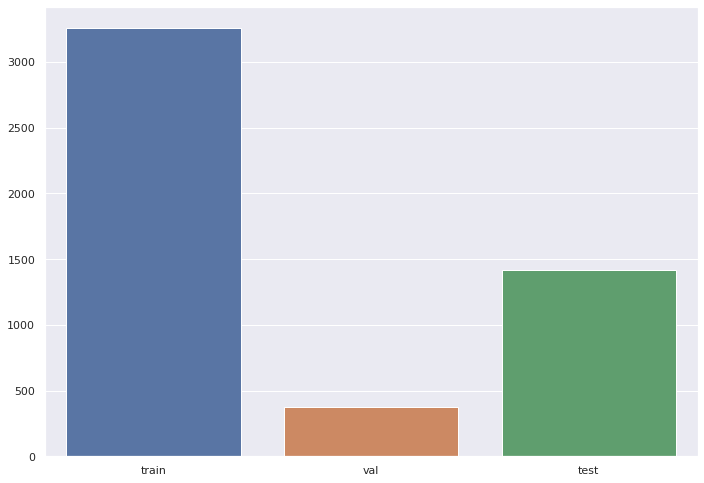

In [13]:
sns.barplot(
    x=['train', 'val', 'test'],
    y=[train_df.shape[0], val_df.shape[0], test_df.shape[0]])

*Plot train populations*

In [14]:
train_df.sentiment.value_counts()

anger       1400
sadness      855
joy          708
optimism     294
Name: sentiment, dtype: int64

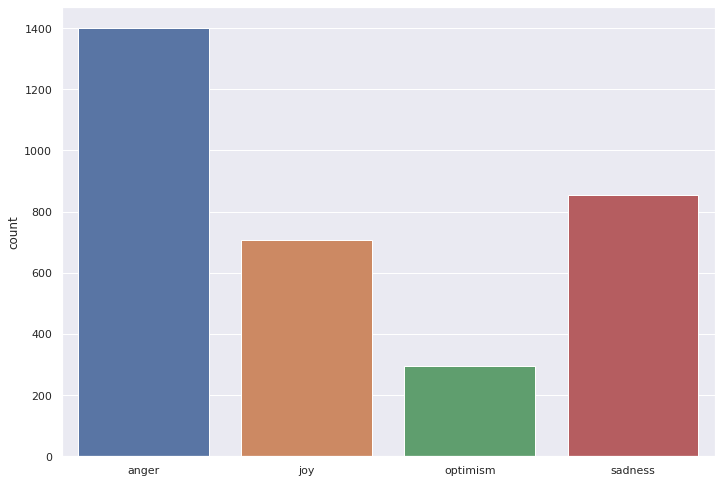

In [15]:
sns.countplot(x=sorted(train_df.sentiment))

*Plot val populations*

In [16]:
val_df.sentiment.value_counts()

anger       160
joy          97
sadness      89
optimism     28
Name: sentiment, dtype: int64

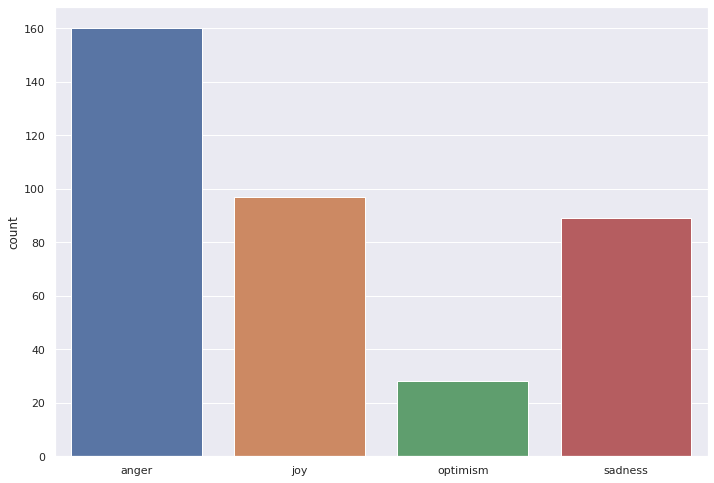

In [17]:
sns.countplot(x=sorted(val_df.sentiment))

*Preprocess text*

In [18]:
# Load tokenizer
tokenizer = ToktokTokenizer()
# Load english stopwords
stopword_list = set(nltk.corpus.stopwords.words('english'))

# Remove special caracters
def remove_special_characters(text):

    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    text = text.replace('\\n', '')  # Remove new line char

    return text

# Remove stopwords
def remove_stopwords(text):

    tokens = tokenizer.tokenize(text)
    tokens = [token.strip().lower() for token in tokens]
    filtered_tokens = [
        token 
        for token in tokens 
        if token not in stopword_list
        if token != 'user']  # Remove redundant term
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

# Pipeline function
def preprocess(text):

    text = remove_special_characters(text)
    text = remove_stopwords(text)

    return text

# Apply function on review column
train_df['processed'] = train_df.tweet.apply(preprocess)
val_df['processed'] = val_df.tweet.apply(preprocess)
test_df['processed'] = test_df.tweet.apply(preprocess)

train_df.head()

,tweet,label,sentiment,processed
0,“Worry is a down payment on a problem you may ...,2,optimism,worry payment problem may never joyce meyer mo...
1,My roommate: it's okay that we can't spell bec...,0,anger,roommate okay cant spell autocorrect terrible ...
2,No but that's so cute. Atsu was probably shy a...,1,joy,thats cute atsu probably shy photos cherry hel...
3,Rooneys fucking untouchable isn't he? Been fuc...,0,anger,rooneys fucking untouchable isnt fucking dread...
4,it's pretty depressing when u hit pan on ur fa...,3,sadness,pretty depressing u hit pan ur favourite highl...


*Lengths of tweets*

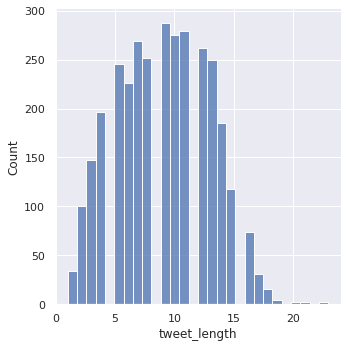

In [19]:
# Compute lenghts
train_df['tweet_length'] = train_df.processed.apply(lambda x: len(x.split()))
sns.displot(x=train_df.tweet_length)

*Sentiments word clouds*

In [20]:
# Generate word clouds
for sentiment in list(labels.values()):

  corpus = ' '.join(train_df[train_df.sentiment == sentiment].processed)
  plt.figure(figsize=(20, 20))
  word_cloud = WordCloud(
      max_words=2000,
      width=1600, 
      height=800, 
      background_color='white')
  word_cloud.generate(corpus)
  plt.axis('off')
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.title(sentiment)

Output hidden; open in https://colab.research.google.com to view.

*Most common words*

In [21]:
# Get top n grams
def get_top_text_ngrams(corpus, n, g):

    vectorizer = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [
        (word, sum_words[0, idx]) 
        for word, idx 
        in vectorizer.vocabulary_.items()]
    words_freq = sorted(
        words_freq,
        key=lambda x: x[1],
        reverse=True)

    return words_freq[:n]

# Plot top n grams
def show_top_ngrams(corpus, n):

  most_common_uni = get_top_text_ngrams(corpus, 20, n)
  most_common_uni = dict(most_common_uni)
  temp = pd.DataFrame(columns=['Common_words', 'Count'])
  temp['Common_words'] = list(most_common_uni.keys())
  temp['Count'] = list(most_common_uni.values())
  fig = px.bar(
      temp,
      x='Count', 
      y='Common_words', 
      title='Commmon Words in Text', 
      orientation='h', 
      width=1200, 
      height=600,
      color='Common_words')
  fig.show()

show_top_ngrams(train_df.processed, 1)

*Bigrams*

In [22]:
show_top_ngrams(train_df.processed, 2)

*Trigrams*

In [23]:
show_top_ngrams(train_df.processed, 3)

# Baseline models  : Logistic Regression with TFIDF & Universal Sentence Encoder

Naive modal class baseline

In [24]:
y_pred_val = [0] * val_df.shape[0]
y_pred_test = [0] * test_df.shape[0]

*Val set*

In [25]:
# Classification report

def report(y_true, y_pred):

  report = classification_report(
      y_true,
      y_pred,
      target_names=labels.values())
  f1 = f1_score(y_true, y_pred, average='macro')
  accuracy = accuracy_score(y_true, y_pred)
  print(report)
  print(f'F1: {f1}')
  print(f'Accuracy: {accuracy}')

report(val_df.label.values, y_pred_val)

              precision    recall  f1-score   support

       anger       0.43      1.00      0.60       160
         joy       0.00      0.00      0.00        97
    optimism       0.00      0.00      0.00        28
     sadness       0.00      0.00      0.00        89

    accuracy                           0.43       374
   macro avg       0.11      0.25      0.15       374
weighted avg       0.18      0.43      0.26       374

F1: 0.149812734082397
Accuracy: 0.42780748663101603


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



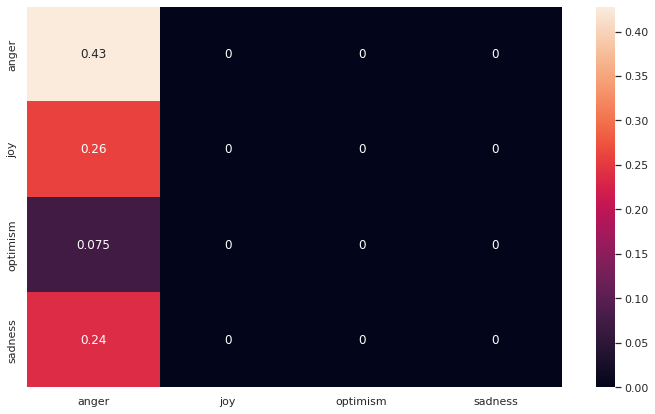

In [26]:
# Confusion matrix
def matrix(y_true, y_pred):

    matrix = confusion_matrix(
        y_true,
        y_pred)
    df_cm = pd.DataFrame(
        matrix/np.sum(matrix),
        index=labels.values(),
        columns=labels.values())
    plt.figure(figsize = (12, 7))
    sns.heatmap(df_cm, annot=True)

matrix(val_df.label.values, y_pred_val)

*Test set*

In [27]:
report(test_df.label.values, y_pred_test)

              precision    recall  f1-score   support

       anger       0.39      1.00      0.56       558
         joy       0.00      0.00      0.00       358
    optimism       0.00      0.00      0.00       123
     sadness       0.00      0.00      0.00       382

    accuracy                           0.39      1421
   macro avg       0.10      0.25      0.14      1421
weighted avg       0.15      0.39      0.22      1421

F1: 0.14098029307731177
Accuracy: 0.39268121041520054


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



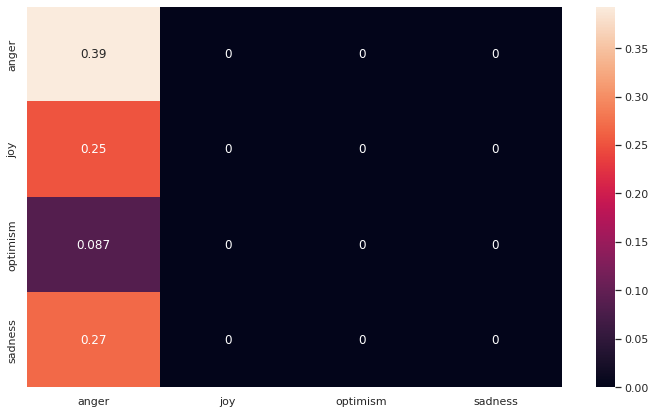

In [28]:
matrix(test_df.label.values, y_pred_test)

*Stem text*

In [29]:
# Stem the words
def simple_stemmer(text):

    stemmer = nltk.porter.PorterStemmer()
    text= ' '.join([
        stemmer.stem(word)
        for word
        in text.split()])

    return text

train_df.processed = train_df.processed.apply(simple_stemmer)
val_df.processed = val_df.processed.apply(simple_stemmer)
test_df.processed = test_df.processed.apply(simple_stemmer)

train_df.head()

,tweet,label,sentiment,processed,tweet_length
0,“Worry is a down payment on a problem you may ...,2,optimism,worri payment problem may never joyc meyer mot...,10
1,My roommate: it's okay that we can't spell bec...,0,anger,roommat okay cant spell autocorrect terribl fi...,7
2,No but that's so cute. Atsu was probably shy a...,1,joy,that cute atsu probabl shi photo cherri help uwu,9
3,Rooneys fucking untouchable isn't he? Been fuc...,0,anger,rooney fuck untouch isnt fuck dread depay look...,9
4,it's pretty depressing when u hit pan on ur fa...,3,sadness,pretti depress u hit pan ur favourit highlight,8


*Apply TFIDF*

In [30]:
# Vectorize using TFIDF
vectorizer = TfidfVectorizer(
    min_df=0,
    max_df=1,
    use_idf=True,
    ngram_range=(1,3))
# Fit transform train reviews
X_train_tfidf = vectorizer.fit_transform(train_df.processed.values)
# Transform val reviews
X_val_tfidf = vectorizer.transform(val_df.processed.values)

X_val_tfidf.shape

(374, 41479)

*Logistic Regression*

In [31]:
# Calculating weights for the imbalanced dataset
weights = compute_class_weight(
    class_weight='balanced',
    classes=list(labels.keys()),
    y=train_df.label.values)

weights

array([0.58160714, 1.15007062, 2.76955782, 0.95233918])

In [32]:
# Train the model with balanced weights
model = LogisticRegression(
    class_weight='balanced',
    multi_class='multinomial',
    solver='lbfgs',
    penalty='l2',
    max_iter=500,
    C=1,
    random_state=42)

# Fitting the model for tfidf features
model.fit(X_train_tfidf, train_df.label.values)

model

LogisticRegression(C=1, class_weight='balanced', max_iter=500,
                   multi_class='multinomial', random_state=42)

In [33]:
# Predict
y_pred_val = model.predict(X_val_tfidf)

y_pred_val[:5]

array([0, 0, 3, 0, 3])

*Val set*

In [34]:
report(val_df.label.values, y_pred_val)

              precision    recall  f1-score   support

       anger       0.44      0.78      0.57       160
         joy       0.47      0.18      0.26        97
    optimism       0.20      0.07      0.11        28
     sadness       0.43      0.22      0.29        89

    accuracy                           0.44       374
   macro avg       0.39      0.31      0.31       374
weighted avg       0.43      0.44      0.39       374

F1: 0.3054783316835506
Accuracy: 0.4385026737967914


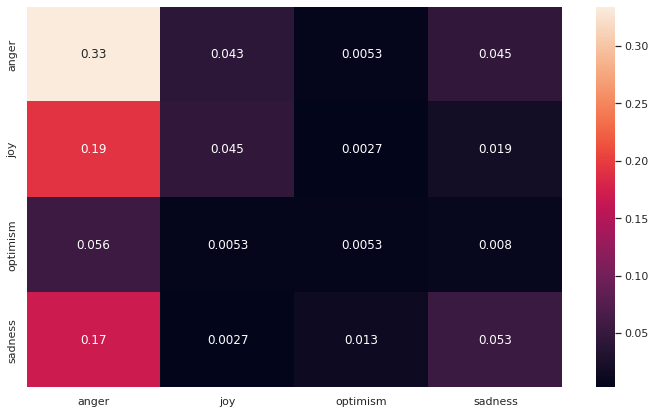

In [35]:
matrix(val_df.label.values, y_pred_val)

*Test set*

In [36]:
X_test_tfidf = vectorizer.transform(test_df.processed.values)
y_pred_test = model.predict(X_test_tfidf)

In [37]:
report(test_df.label.values, y_pred_test)

              precision    recall  f1-score   support

       anger       0.43      0.82      0.56       558
         joy       0.42      0.16      0.24       358
    optimism       0.25      0.04      0.07       123
     sadness       0.39      0.20      0.26       382

    accuracy                           0.42      1421
   macro avg       0.37      0.30      0.28      1421
weighted avg       0.40      0.42      0.36      1421

F1: 0.2826272597293854
Accuracy: 0.4187192118226601


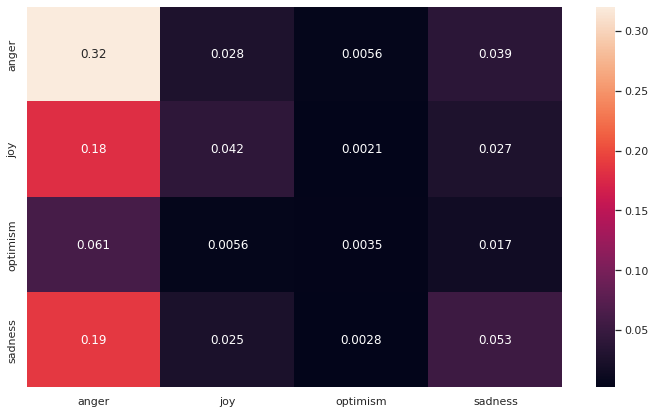

In [38]:
matrix(test_df.label.values, y_pred_test)

*Universal Sentence Encoder* [[reference]](https://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07D%20-%20Text%20Classification%20Deep%20Transfer%20Learning%20with%20Universal%20Embeddings.ipynb#scrollTo=dK2z9pbXspoR)



In [39]:
# Create generators
train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    {'sentence': train_df.processed.values},
    train_df.label.values, 
    batch_size=256,
    num_epochs=None,
    shuffle=True)
predict_train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    {'sentence': train_df.processed.values}, train_df.label.values, shuffle=False)
predict_val_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    {'sentence': val_df.processed.values}, val_df.label.values, shuffle=False)
predict_test_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
    {'sentence': test_df.processed.values}, test_df.label.values, shuffle=False)

In [40]:
# Import embeddings
embedding_feature = hub.text_embedding_column(
    key='sentence', 
    module_spec="https://tfhub.dev/google/universal-sentence-encoder/2",
    trainable=False)

In [41]:
# Init model
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

encoder = tf.compat.v1.estimator.DNNClassifier(
          hidden_units=[512, 128],
          feature_columns=[embedding_feature],
          n_classes=n_labels,
          activation_fn=tf.nn.relu,
          dropout=0.3,
          optimizer=tf.compat.v1.train.AdagradOptimizer(learning_rate=0.0005))

In [42]:
# Train model
TOTAL_STEPS = 1500
STEP_SIZE = 100
for step in range(0, TOTAL_STEPS, STEP_SIZE):
    print('Training for step:', step, '-', step+STEP_SIZE)
    encoder.train(input_fn=train_input_fn, steps=STEP_SIZE)
    print('Train Metrics:', encoder.evaluate(input_fn=predict_train_input_fn))
    print('Eval Metrics:', encoder.evaluate(input_fn=predict_val_input_fn))

Training for step: 0 - 100
Train Metrics: {'accuracy': 0.4783543, 'average_loss': 1.1980374, 'loss': 150.07722, 'global_step': 100}
Eval Metrics: {'accuracy': 0.46256685, 'average_loss': 1.2065619, 'loss': 150.41805, 'global_step': 100}
Training for step: 100 - 200
Train Metrics: {'accuracy': 0.5677003, 'average_loss': 1.0909345, 'loss': 136.66054, 'global_step': 200}
Eval Metrics: {'accuracy': 0.5240642, 'average_loss': 1.110723, 'loss': 138.47014, 'global_step': 200}
Training for step: 200 - 300
Train Metrics: {'accuracy': 0.6079214, 'average_loss': 1.0180697, 'loss': 127.53282, 'global_step': 300}
Eval Metrics: {'accuracy': 0.54812837, 'average_loss': 1.0460409, 'loss': 130.40643, 'global_step': 300}
Training for step: 300 - 400
Train Metrics: {'accuracy': 0.6257292, 'average_loss': 0.97213894, 'loss': 121.7791, 'global_step': 400}
Eval Metrics: {'accuracy': 0.5855615, 'average_loss': 1.0083619, 'loss': 125.70913, 'global_step': 400}
Training for step: 400 - 500
Train Metrics: {'acc

In [43]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

# Predict
y_pred_val = get_predictions(encoder, predict_val_input_fn)
y_pred_test = get_predictions(encoder, predict_test_input_fn)

*Val set*

In [44]:
report(val_df.label.values, y_pred_val)

              precision    recall  f1-score   support

       anger       0.64      0.81      0.71       160
         joy       0.55      0.48      0.52        97
    optimism       0.00      0.00      0.00        28
     sadness       0.59      0.56      0.57        89

    accuracy                           0.61       374
   macro avg       0.44      0.46      0.45       374
weighted avg       0.56      0.61      0.58       374

F1: 0.4513704686118479
Accuracy: 0.606951871657754


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



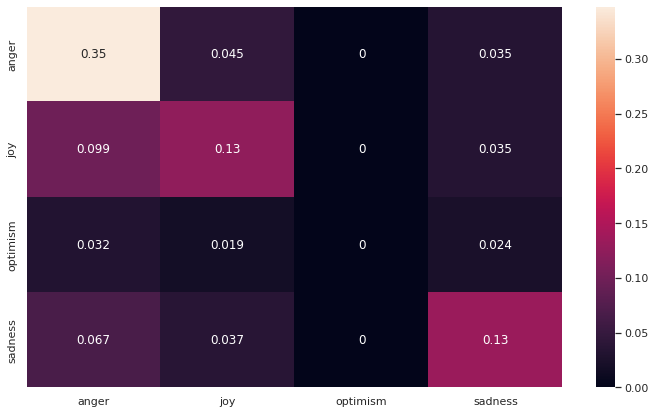

In [45]:
matrix(val_df.label.values, y_pred_val)

*Test set*

In [46]:
report(test_df.label.values, y_pred_test)

              precision    recall  f1-score   support

       anger       0.63      0.83      0.72       558
         joy       0.67      0.62      0.64       358
    optimism       0.60      0.05      0.09       123
     sadness       0.68      0.62      0.65       382

    accuracy                           0.65      1421
   macro avg       0.64      0.53      0.52      1421
weighted avg       0.65      0.65      0.63      1421

F1: 0.5241668214566055
Accuracy: 0.6516537649542575


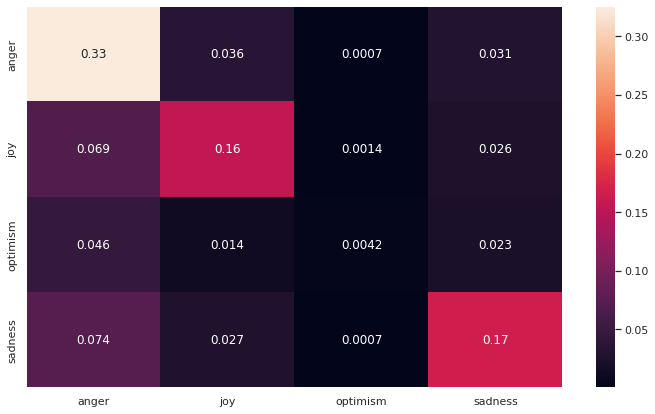

In [47]:
matrix(test_df.label.values, y_pred_test)

# State-of-the-Art model: DeBERTaV3 base
[[reference]](https://colab.research.google.com/github/abhimishra91/transformers-tutorials/blob/master/transformers_sentiment_wandb.ipynb)

*Custom dataset*

In [48]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):

        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):

        text = str(self.data.tweet[index])
        text = ' '.join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True)
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        types = inputs['token_type_ids']

        return {
            'ids': torch.tensor(
                ids,
                dtype=torch.long),
            'mask': torch.tensor(
                mask,
                dtype=torch.long),
            'types': torch.tensor(
                types, 
                dtype=torch.long),
            'targets': torch.tensor(
                self.data.label[index],
                dtype=torch.float)} 
    
    def __len__(self):

        return self.len


*Gen dataloaders*

In [49]:
def return_dataloader(train_dataset, val_dataset, test_dataset, tokenizer, train_batch_size, validation_batch_size, MAX_LEN):

    training_set = CustomDataset(
        train_dataset,
        tokenizer,
        MAX_LEN)
    validation_set = CustomDataset(
        val_dataset,
        tokenizer, 
        MAX_LEN)
    test_set = CustomDataset(
        test_dataset,
        tokenizer, 
        MAX_LEN)
    train_params = {
        'batch_size': train_batch_size,
        'shuffle': True,
        'num_workers': 1}
    val_params = {
        'batch_size': validation_batch_size,
        'shuffle': True,
        'num_workers': 1}
    test_params = {
        'batch_size': validation_batch_size,
        'shuffle': True,
        'num_workers': 1}
    training_loader = DataLoader(
        training_set,
        **train_params)
    validation_loader = DataLoader(
        validation_set,
        **val_params)
    test_loader = DataLoader(
        test_set,
        **val_params)
    
    return training_loader, validation_loader, test_loader


*Custom model*

In [50]:
class ModelClass(torch.nn.Module):

    def __init__(self, transformer):

        super(ModelClass, self).__init__()
        self.model_layer = transformer
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, n_labels) # <- 20 labels

    def forward(self, input_ids, attention_mask, token_type_ids):

        output_1 = self.model_layer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)

        return output


*Gen model*

In [51]:
def return_model(transformer, device):

    model = ModelClass(transformer)
    model = model.to(device)

    return model


*Compute accuracy*

In [52]:
def calculate_accu(big_idx, targets):

    n_correct = (big_idx == targets).sum().item()

    return n_correct


*Training func*

In [53]:
def train(epoch, model, device, training_loader, optimizer, loss_function):

    y_true, y_pred = list(), list()
    n_correct = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_loss = 0
    model.train()

    for _, data in enumerate(training_loader, 0):

        optimizer.zero_grad()

        ids = data['ids'].to(
            device,
            dtype=torch.long)
        mask = data['mask'].to(
            device,
            dtype=torch.long)
        types = data['types'].to(
            device,
            dtype=torch.long)
        targets = data['targets']
        targets = targets.to(
            device,
            dtype=torch.long)

        outputs = model(
            input_ids=ids,
            attention_mask=mask, 
            token_type_ids=types)
        outputs = outputs.squeeze(dim=1)

        loss = loss_function(
            outputs,
            targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(
            outputs.data,
            dim=1)
        n_correct += calculate_accu(big_idx, targets)
        y_true += targets.tolist()
        y_pred += big_idx.tolist()
        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%100==0:

            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            f1_step = f1_score(y_true, y_pred, average='macro')*100
            wandb.log({'Training Loss per 100 steps': loss_step})
            wandb.log({'Training Accuracy per 100 steps': accu_step})
            wandb.log({'Training F1 score per 100 steps': f1_step})

        loss.backward()
        optimizer.step()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # When using GPU
        # optimizer.step()
        
        # When using TPU
        xm.optimizer_step(optimizer)
        xm.mark_step()

    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    epoch_f1 = f1_score(y_true, y_pred, average='macro')*100
    wandb.log({'Training Loss Epoch': epoch_loss})
    wandb.log({'Training Accuracy Epoch': epoch_accu})
    wandb.log({'Training F1 score Epoch': epoch_f1})
    print(f'The Total Accuracy for Epoch {epoch}: {epoch_accu}')
    print(f'The Total F1 score for Epoch {epoch}: {epoch_f1}')


*Validation func*

In [54]:
def valid(epoch, model, device, loader, loss_function, subset='Validation'):

    y_true, y_pred = list(), list()
    n_correct = 0; total = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_loss = 0
    model.eval()

    with torch.no_grad():

        for _, data in enumerate(loader, 0):

            ids = data['ids'].to(
                device, 
                dtype=torch.long)
            mask = data['mask'].to(
                device,
                dtype=torch.long)
            types = data['types'].to(
                device,
                dtype=torch.long)
            targets = data['targets'].to(
                device,
                dtype=torch.long)

            outputs = model(
                input_ids=ids,
                attention_mask=mask,
                token_type_ids=types)
            outputs = outputs.squeeze(dim=1)
            loss = loss_function(
                outputs,
                targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calculate_accu(big_idx, targets)

            y_true += targets.tolist()
            y_pred += big_idx.tolist()
            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%100==0:

                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples 
                f1_step = f1_score(y_true, y_pred, average='macro')*100
                wandb.log({f'{subset} Loss per 100 steps': loss_step})
                wandb.log({f'{subset} Accuracy per 100 steps': accu_step})
                wandb.log({f'{subset} F1 score per 100 steps': f1_step})

    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    epoch_f1 = f1_score(y_true, y_pred, average='macro')*100
    wandb.log({f'{subset} Loss Epoch': epoch_loss})
    wandb.log({f'{subset} Accuracy Epoch': epoch_accu})
    wandb.log({f'{subset} F1 score Epoch': epoch_f1})
    print(f'The {subset} Accuracy: {epoch_accu}')
    print(f'The {subset} F1 score: {epoch_f1}')

    return y_true, y_pred


*Run pipeline*

In [55]:
def run(train_df, val_df):

    # WandB – Initialize a new run
    wandb.init(project='tweet_emotions')

    # Defining some key variables that will be used later on in the training
    config = wandb.config 
    config.MAX_LEN = 280
    config.TRAIN_BATCH_SIZE = 4
    config.VALID_BATCH_SIZE = 2
    config.EPOCHS = 3
    config.LEARNING_RATE = 1e-05
    tokenizer = AutoTokenizer.from_pretrained(MODEL)

    # Creating the training and validation dataloader using the functions defined above
    training_loader, validation_loader, test_loader = return_dataloader(
        train_df,
        val_df,
        test_df,
        tokenizer, 
        config.TRAIN_BATCH_SIZE,
        config.VALID_BATCH_SIZE,
        config.MAX_LEN)

    # Defining the model based on the function and ModelClass defined above
    transformer = AutoModel.from_pretrained(MODEL)
    model = return_model(transformer, device)

    # Creating the loss function and optimizer
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=config.LEARNING_RATE)

    # Fine tuning the model using the train function:
    print('Training model...')
    for epoch in range(config.EPOCHS):
        train(
            epoch,
            model,
            device,
            training_loader,
            optimizer,
            loss_function)

    # Running the validation function to validate the performance of the trained model
    print('Evaluating model on validation set...')
    y_true_val, y_pred_val = valid(
        epoch,
        model,
        device,
        validation_loader,
        loss_function)

    print('Evaluating model on test set...')
    y_true_test, y_pred_test = valid(
        epoch,
        model,
        device,
        test_loader,
        loss_function,
        subset='Test')

    return y_true_val, y_pred_val, y_true_test, y_pred_test


*Run*

In [56]:
y_true_val, y_pred_val, y_true_test, y_pred_test = run(train_df, val_df)

wandb: Currently logged in as: thibaudg. Use `wandb login --relogin` to force relogin


Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/579 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/354M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training model...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



The Total Accuracy for Epoch 0: 67.91525944120356
The Total F1 score for Epoch 0: 61.54056628116691


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



The Total Accuracy for Epoch 1: 83.94227817009518
The Total F1 score for Epoch 1: 80.78701276678892


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



The Total Accuracy for Epoch 2: 89.77586736260362
The Total F1 score for Epoch 2: 87.78303724110867
Evaluating model on validation set...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



The Validation Accuracy: 83.68983957219251
The Validation F1 score: 76.855937433648
Evaluating model on test set...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



The Test Accuracy: 84.72906403940887
The Test F1 score: 82.46227700839259


*Val*

In [57]:
report(y_true_val, y_pred_val)

              precision    recall  f1-score   support

       anger       0.86      0.94      0.90       160
         joy       0.86      0.80      0.83        97
    optimism       0.54      0.50      0.52        28
     sadness       0.87      0.80      0.83        89

    accuracy                           0.84       374
   macro avg       0.78      0.76      0.77       374
weighted avg       0.84      0.84      0.83       374

F1: 0.7685593743364799
Accuracy: 0.8368983957219251


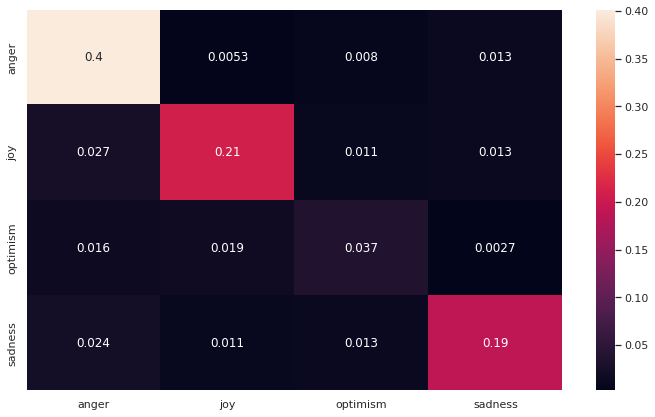

In [58]:
matrix(y_true_val, y_pred_val)

*Test*

In [59]:
report(y_true_test, y_pred_test)

              precision    recall  f1-score   support

       anger       0.84      0.91      0.87       558
         joy       0.85      0.86      0.85       358
    optimism       0.83      0.67      0.74       123
     sadness       0.86      0.81      0.83       382

    accuracy                           0.85      1421
   macro avg       0.84      0.81      0.82      1421
weighted avg       0.85      0.85      0.85      1421

F1: 0.8246227700839259
Accuracy: 0.8472906403940886


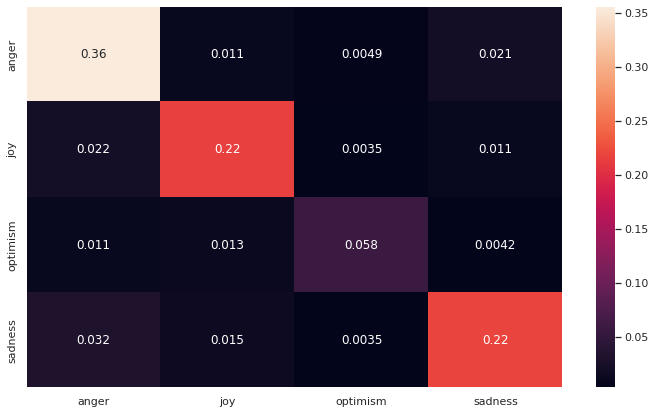

In [60]:
matrix(y_true_test, y_pred_test)

A performance report is available at the following address: https://wandb.ai/thibaudg/tweet_emotions/reports/DeBERTaV3-vs-BERT--VmlldzoyMDg0MjM0?accessToken=zlotac9mqojizuu7jv7eo6jzyzbcn9l78m48nxxp6au77y9sghkmec2b97hl88tn